In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv("data.csv")
X_train = data[['feature1', 'feature2']].values
Y_train = data['class'].values

In [5]:
labels = list(set(Y_train))
depth = len(labels)
print("labels: ", labels)
with tf.Session() as sess:
    YtrainOneHot = tf.one_hot(Y_train, depth, axis = 0)
    Y_train = sess.run(YtrainOneHot)
X_train = X_train.T
print("X_train dimension:{} ,Y_train dimention:{}".format(X_train.shape, Y_train.shape))

labels:  [0.0, 1.0, 2.0, 3.0]
X_train dimension:(2, 2000) ,Y_train dimention:(4, 2000)


In [19]:
Y_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 1.,  1.,  1., ...,  0.,  1.,  0.]], dtype=float32)

In [6]:
layer_dims = [2,25,12,4]

In [7]:
def placeholders(num_features, num_classes):
    A_0 = tf.placeholder(dtype = tf.float64, shape = ([num_features,None]))
    Y = tf.placeholder(dtype = tf.float64, shape = ([num_classes,None]))
    return A_0,Y

In [8]:
def initialize_parameters_deep(layer_dims):
    L = len(layer_dims)
    parameters = {}
    for l in range(1,L):
        parameters['W' + str(l)] = tf.Variable(initial_value=tf.random_normal([layer_dims[l], layer_dims[l-1]], dtype=tf.float64) * 0.01)
        parameters['b' + str(l)] = tf.Variable(initial_value=tf.zeros([layer_dims[l],1], dtype=tf.float64))
    return parameters 

In [9]:
def linear_forward_prop(A_prev,W,b, activation):
    Z = tf.add(tf.matmul(W, A_prev), b)
    if activation == "softmax":
        A = Z
    elif activation == "relu":
        A = tf.nn.relu(Z)
    return A

In [10]:
def l_layer_forwardProp(A_0, parameters):
    A = A_0
    L = len(parameters)//2
    for l in range(1,L):
        A_prev = A
        A = linear_forward_prop(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
    A = linear_forward_prop(A, parameters['W' + str(L)], parameters['b' + str(L)], "softmax" )
    return A

In [11]:
def final_cost(Z_final, Y ):
    logits = tf.transpose(Z_final)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels))
    return cost

In [12]:
def random_samples_minibatch(X_train, Y_train, batch_size, seed = 1):
    np.random.seed(seed)
    m = X_train.shape[1]
    num_batches = int(m/batch_size)
    indices = np.random.permutation(m)
    shuffle_X = X_train[:,indices]
    shuffle_Y = Y_train[:,indices]
    mini_batches = []
    for i in range(num_batches):
        X_batch = shuffle_X[:,i * batch_size:(i+1) * batch_size]
        Y_batch = shuffle_Y[:,i * batch_size:(i+1) * batch_size]
        mini_batches.append((X_batch, Y_batch))
    if m % batch_size != 0:
        X_batch = shuffle_X[:, (num_batches * batch_size):]
        Y_batch = shuffle_Y[:, (num_batches * batch_size):]
        mini_batches.append((X_batch, Y_batch))
    return mini_batches

In [13]:
def model_with_minibatch(X_train,Y_train, layer_dims, learning_rate, num_iter, mini_batch_size):
    num_features, num_samples = X_train.shape
    num_classes = Y_train.shape[0]
    A_0, Y = placeholders(num_features, num_classes)
    parameters = initialize_parameters_deep(layer_dims)
    Z_final = l_layer_forwardProp(A_0, parameters)
    cost = final_cost(Z_final, Y)
    train_net = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    seed = 1
    num_minibatches = int(num_samples / mini_batch_size)
    init = tf.global_variables_initializer()
    costs = []
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_iter):
            epoch_cost = 0
            mini_batches = random_samples_minibatch(X_train, Y_train, mini_batch_size, seed)
            seed = seed + 1
            for mini_batch in mini_batches:
                X_batch, Y_batch = mini_batch
                _,mini_batch_cost = sess.run([train_net, cost], feed_dict={A_0: X_batch, Y: Y_batch})
                epoch_cost += mini_batch_cost/num_minibatches
            if epoch % 10 == 0:
                costs.append(epoch_cost)
            if epoch % 100 == 0:
                print(epoch_cost)
        plt.ylim(0.2, 3, 0.01)
        plt.xlabel("epoches per 100")
        plt.ylabel("cost")
        plt.plot(costs)
        plt.show()
        params = sess.run(parameters)
    return params

1.40877223877
0.288374120551
0.265945903718
0.266034344843
0.264382753836
0.262970686931
0.262839480878
0.259844141615
0.261853512575
0.258346650252


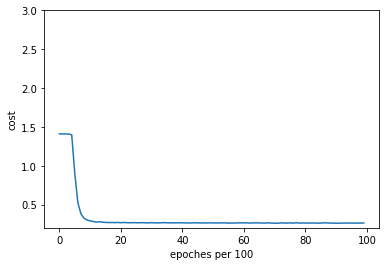

In [14]:
params = model_with_minibatch(X_train, Y_train, layer_dims, 0.01, 1000, 32)

In [18]:
def predict(X_train, params):
    with tf.Session() as sess:
        Y = tf.arg_max(l_layer_forwardProp(X_train,params), dimension=1)
        return sess.run(Y)

In [19]:
def plot_decision_boundary1( X, y, model):
    plt.clf()
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1   
    colors=['blue','green','red', 'yellow']
    cmap = matplotlib.colors.ListedColormap(colors)   
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    A = model(np.c_[xx.ravel(), yy.ravel()])
    A = A.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, A, cmap="spring")
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, s=8,cmap=cmap)
    plt.title("Decision Boundary for learning rate:")
    plt.show()

In [ ]:
plot_decision_boundary1(X_train,Y_train,lambda x: predict(x.T,params))